In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import sys
import calendar

sys.path.append(os.path.abspath("./Code"))
sys.path.append(os.path.abspath("./Data"))

from RO_solver import *
from RO_solver_analytic import *
from RO_std_analytic import *
from RO_BWJ import *
from RO_fitting import *
from func_mon_std import *
from par_load import *

In [2]:
# This template allows users to easily configure options for solving the RO model.
# -------------------------------------------------------------------------
# RO model Equations
# --------------------------------------------------------------------------
# dT/dt=R*T+F1*h+b_T*(T^2)-c_T*(T^3)+d_T*(T*h)+sigma_T*(1+B*G(T)*T)*noise_T
# dh/dt=-F2*T-epsilon*h-b_h*(T^2)+sigma_h*noise_h
# --------------------------------------------------------------------------
# If noise is white: 
# noise_T=w_T (n_T=1)
# noise_h=w_h (n_h=1)
#--------------------------------------------------------------------------
# If noise is red: 
# d(noise_T)/dt=-m_T*T+sqrt(2*m_T)*w_T (n_T=0)
# d(noise_h)/dt=-m_h*h+sqrt(2*m_h)*w_h (n_h=0)
#--------------------------------------------------------------------------
# If T noise type is: 
# Additive: G(T)=1 (n_g=2)
# Multiplicative-Linear: G(T)=B*T (n_g=0) 
# Multiplicative-Heaviside: G(T)=B*H(T)*T (n_g=1)
#--------------------------------------------------------------------------
# Setting RO Parameter
# Choose one of the following to set 'par' (Method 1, 2 and 3)

In [10]:
# Method 1: Use a predefined Parameter Library set
# Select and replace with the option you wish to run
data_name = "ORAS5"                 # data_name = "ORAS5"
                                    # → loads the ORAS5 dataset (reference reanalysis)
                                    #
                                    # data_name = "CMIP6-historical-1" ... "CMIP6-historical-48"
                                    # → loads the nth CMIP6 historical ensemble member
                                    #
                                    # data_name = "CMIP6-historical-all"
                                    # → loads all 48 available CMIP6 ensemble members.
                                    # In this case, par.shape == (48, 16), i.e. 48 rows of parameter sets.
                                    # Use par[i] (0 ≤ i < 48) to extract parameters from the ensemble member of your choice.
                                    # Be careful with indexing: i = 0..(47) extract CMIP6-historical-1..(48). 

RO_type = "Seasonal-Linear-White-Additive"   # RO type for fitted parameters; 8 options available (see CRO manual for full list) 
par = par_load(data_name,RO_type)
print(par)

{'R': [-0.06383901962500646, -0.14530209906324634, 0.5161836352414841],
 'F1': [0.013673357129605964],
 'F2': [1.2939079422481348],
 'epsilon': [0.008754185790444461],
 'b_T': [],
 'c_T': [],
 'd_T': [],
 'b_h': [],
 'sigma_T': [0.20224120740253798],
 'sigma_h': [1.5547824185851542],
 'B': [],
 'm_T': [],
 'm_h': [],
 'n_T': [1],
 'n_h': [1],
 'n_g': [2]}


/Users/sooman/anaconda3/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [11]:
# Method 2: Use a custom (user-specified) parameter set
# Define and replace with the specific parameter values you want to run
par = {'R': [-0.05, 0.10, np.pi, 0.025, 0],       # dT/dt=R*T (unit: month^-1)        
       'F1': [0.02],                              # dT/dt=F1*h (unit: K m^-1 month^-1)
       'F2': [0.9],                               # dh/dt=-F2*T (unit: m K^-1 month^-1)
       'epsilon': [0.03],                         # dh/dt=-epsilon*h (unit: month^-1)
       'b_T': [],                                 # dT/dt=(b_T)*(T^2) (unit: K^-1 month^-1)
       'c_T': [],                                 # dT/dt=-(c_T)*(T^3) (unit: K^-2 month^-1)
       'd_T': [],                                 # dT/dt=(d_T)*(T*h) (unit: m^-1 month^-1)
       'b_h': [],                                 # dh/dt=-(b_h)*(T^2) (unit: K^-2 m month^-1)
       'sigma_T': [0.2],                          # dT/dt=(sigma_T)*(N_T) (unit: K month^-0.5 if n_T=1, K month^-1 if n_T=0)
       'sigma_h': [1.2],                          # dh/dt=(sigma_h)*(N_h) (unit: m month^-0.5 if n_h=1, m month^-1 if n_h=0)
       'B': [],                                   # T/dt=(sigma_T)*(1+B*T)*(N_T) or dT/dt=(sigma_T)*(1+B*H(T)*T)*(N_T) (unit: K^-1)
       'm_T': [1.0],                              # d(xi_T)/dt=-m*T*(xi_T); (unit: month^-1)
       'm_h': [1.0],                              # d(xi_h)/dt=-m*h*(xi_h); (unit: month^-1)
       'n_T': [0],                                # noise type for T (0: red noise, 1: white noise) (unitless)
       'n_h': [0],                                # noise type for h (0: red noise, 1: white noise) (unitless)
       'n_g': [0]}                                # multiplicative noise type for T (0: linear, 1: Heaviside linear, 2: omit this option) 
                                                  # (note: only valid when B is not zero) (unitless)
print(par)

{'R': [-0.05, 0.1, 3.141592653589793, 0.025, 0],
 'F1': [0.02],
 'F2': [0.9],
 'epsilon': [0.03],
 'b_T': [],
 'c_T': [],
 'd_T': [],
 'b_h': [],
 'sigma_T': [0.2],
 'sigma_h': [1.2],
 'B': [],
 'm_T': [1.0],
 'm_h': [1.0],
 'n_T': [0],
 'n_h': [0],
 'n_g': [0]}


In [5]:
# Method 3: Use returned by 'RO_fitting' function 
# Refer to 'CRO_template_fitting.ipynb' to see how to obtain the 'par' using 
# 'RO_fitting' using your own T and h data for a user-selected RO type. 

In [6]:
# setup for RO simulations
IC = [1.0, 0.0]              # Initial conditions for T and h
N = 12 * 100                 # Simulation length in months (e.g., 100 years)
NE = 10                      # Number of ensemble members
NM = "EH"                    # Optional: Numerical integration method for
                             #           RO solver "EH" (Euler–Heun, default) 
                             #           or "EM" (Euler–Maruyama)
dt = 0.1                     # Optional: Time step for numerical integration 
                             #           in months. Default = 0.1
saveat = 1.0                 # Optional: Interval for saving outputs in months. 
                             #           Default = 1.0
savemethod = "sampling"      # Optional: Output method. "sampling" saves 
                             #           instantaneous values, "mean" saves 
                             #           time-averaged values over each save 
                             #           interval. Default = "sampling"
EF = None                    # Optional: External forcing dictionary.
                             #           If EF is None (or not specified), 
                             #           it defaults to:
                             #           EF = {'E_T': [0.0], 'E_h': [0.0]}
                             #           Same format and interpretation as 
                             #           other RO parameters. Example:
                             #           EF = {'E_T': [-0.01, 0.02, np.pi],
                             #                 'E_h': [-0.01]}
noise_custom = None          # Optional: Noise specification.
                             #   - If None or not provided: 
                             #     uses internally generated noise 
                             #     (different each run; Default)
                             #   - If an integer: uses as the random seed for
                             #     reproducible noise with the reference number
                             #   - If ndarray: user-supplied noise 
                             #     (shape must be (int(N/dt) - 1, 4))
                             #     The first two columns of the noise array are 
                             #     applied to the main T and h equations.
                             #     The last two columns are used as noise terms 
                             #     for the red noise processes.

In [7]:
# Run RO simulations with your setup and parameter set (par)
T_ro, h_ro, _ = RO_solver(par, IC, N, NE, NM, dt, saveat, savemethod, EF, noise_custom) 
time_axis = np.arange(0, N, saveat)

---------------------------------------------------------------------------------
Welcome to the CRO Solver! Your simulation setup is as follows:
---------------------------------------------------------------------------------
 - Total simulation length: N = 1200 months
 - Number of ensemble members: NE = 10
 - Numerical integration time step: dt = 0.1 months (default: 0.1)
 - Data output interval: saveat = 1.0 months (default: 1.0)
 - Initial conditions: IC = [T0, h0] = [1.0, 0.0]
 - Input parameters have the expected shapes.
 - 'n_T' = 0: Red noise forcing in the T equation with m_T = [1.0, 0.0, 0.0, 0.0, 0.0].
 - 'n_h' = 0: Red noise forcing in the h equation with m_h = [1.0, 0.0, 0.0, 0.0, 0.0].
 - 'n_g' = 0: Multiplicative noise (1 + B*T) is used in the T equation.
 - Numerical integration method: NM = 'EH' (Euler–Heun method; default)
 - Data saving method: savemethod = sampling (default)
 - External forcing is not given, therefore using
   EF = {'E_T': [0.0, 0.0, 0.0, 0.0, 0.0]

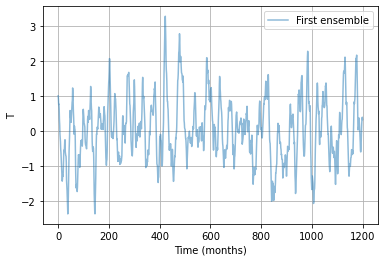

In [8]:
# plot first ensemble
num_en = 0 

plt.figure()
plt.plot(time_axis, T_ro[:, num_en],  label='First ensemble',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()

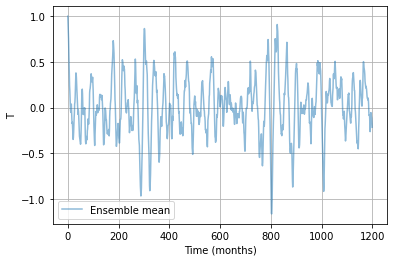

In [9]:
# plot ensemble mean
plt.figure()
plt.plot(time_axis, np.mean(T_ro, axis=1),  label='Ensemble mean',  alpha=0.5)
plt.xlabel("Time (months)")
plt.ylabel("T")
plt.legend()
plt.grid()
plt.show()